In [1]:
import cv2
import os
import random 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
len(gpus)

0

In [5]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
import uuid

In [7]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\75ddfa01-4f75-11ef-a621-ac198eeec063.jpg'

In [8]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()


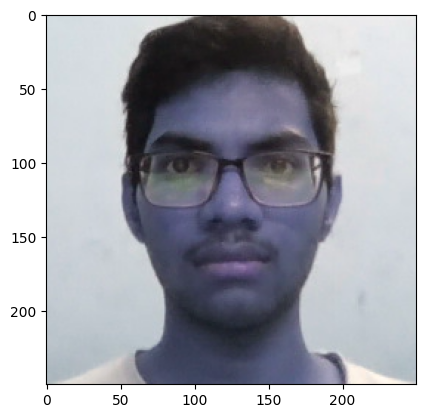

In [9]:
plt.imshow(frame)

In [10]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [11]:
dir_test = anchor.as_numpy_iterator()

In [12]:
print(dir_test.next())

b'data\\anchor\\492b1a2d-4f4b-11ef-afaa-a0b2a256553f.jpg'


In [13]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [14]:
img = preprocess('data\\anchor\\4043dddc-4f4b-11ef-8f67-a0b2a256553f.jpg')

In [15]:
img.numpy().min() 

0.0

In [16]:
img.numpy().max() 

0.76960784

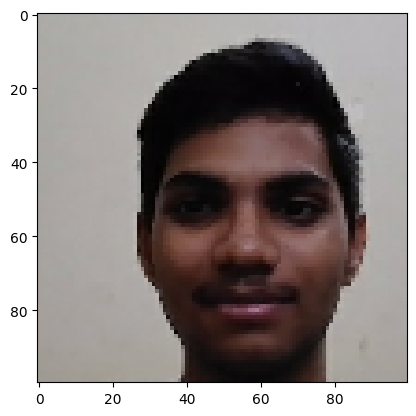

In [17]:
plt.imshow(img)

In [18]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [19]:
samples = data.as_numpy_iterator()

In [20]:
example = samples.next()

In [21]:
example

(b'data\\anchor\\4067b847-4f4b-11ef-b44d-a0b2a256553f.jpg',
 b'data\\positive\\74f9234f-4f4b-11ef-9538-a0b2a256553f.jpg',
 1.0)

In [22]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [23]:
res = preprocess_twin(*example)

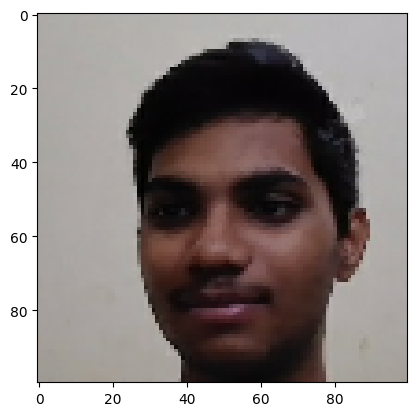

In [24]:
plt.imshow(res[0])

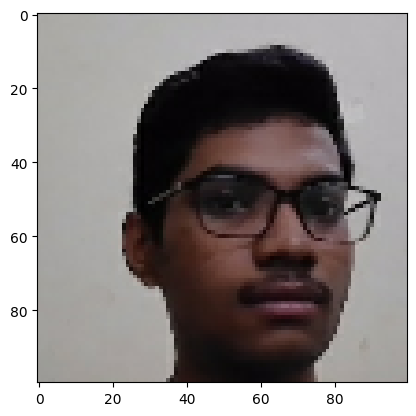

In [25]:
plt.imshow(res[1])

In [26]:
res[2]

1.0

In [27]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [28]:
samples=data.as_numpy_iterator()

In [29]:
len(samples.next())

3

In [30]:
samp=samples.next()

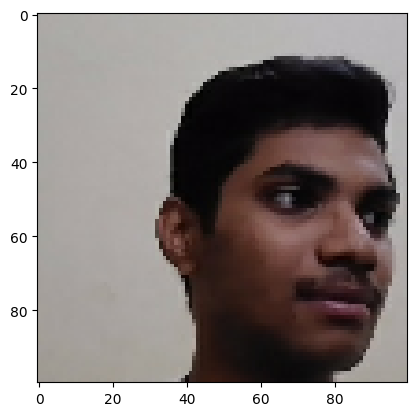

In [31]:
plt.imshow(samp[0])

In [32]:
samp[2]

0.0

In [33]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [34]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [35]:
inp = Input(shape=(100,100,3), name='input_image')

In [36]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [37]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [38]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [39]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [40]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [41]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [42]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [44]:
embedding = make_embedding()

In [45]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super(L1Dist,self).__init__(**kwargs)
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        input_embedding=tf.convert_to_tensor(input_embedding)
        validation_embedding=tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)
    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [47]:
l1 = L1Dist()

In [48]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [49]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [50]:
siamese_layer = L1Dist()

In [51]:
distances = siamese_layer(inp_embedding, val_embedding)

In [52]:
classifier = Dense(1, activation='sigmoid')(distances)

In [53]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_21>

In [54]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [55]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [57]:
siamese_model = make_siamese_model()

In [58]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_2 (L1Dist)            │ (None, 4096)              │               0 │ embedding[2][0],           │
│                               │                           │                 │ embedding[3][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [60]:
opt = tf.keras.optimizers.Adam(1e-4) 

In [61]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [62]:
test_batch = train_data.as_numpy_iterator()

In [63]:
batch_1 = test_batch.next()

In [64]:
X = batch_1[0]

In [65]:
X

array([[[[0.654902  , 0.6509804 , 0.63529414],
         [0.65882355, 0.654902  , 0.6392157 ],
         [0.6627451 , 0.65882355, 0.6431373 ],
         ...,
         [0.70980394, 0.7019608 , 0.7137255 ],
         [0.7129902 , 0.7051471 , 0.7169118 ],
         [0.7137255 , 0.7058824 , 0.7176471 ]],

        [[0.654902  , 0.6509804 , 0.63529414],
         [0.65882355, 0.654902  , 0.6392157 ],
         [0.65882355, 0.654902  , 0.6392157 ],
         ...,
         [0.7088235 , 0.70098037, 0.7127451 ],
         [0.70980394, 0.7019608 , 0.7137255 ],
         [0.70980394, 0.7019608 , 0.7137255 ]],

        [[0.65563726, 0.6517157 , 0.6360294 ],
         [0.65588236, 0.6519608 , 0.6362745 ],
         [0.65588236, 0.6519608 , 0.6362745 ],
         ...,
         [0.7058824 , 0.69803923, 0.70980394],
         [0.70906866, 0.7012255 , 0.7129902 ],
         [0.7058824 , 0.69803923, 0.70980394]],

        ...,

        [[0.61960787, 0.6039216 , 0.5686275 ],
         [0.6156863 , 0.6       , 0.5647059 ]

In [66]:
y = batch_1[1]

In [67]:
y

array([[[[6.69607818e-01, 6.65686250e-01, 6.46078408e-01],
         [6.74509823e-01, 6.70588255e-01, 6.50980413e-01],
         [6.74509823e-01, 6.70588255e-01, 6.50980413e-01],
         ...,
         [7.15686262e-01, 7.07843125e-01, 7.19607830e-01],
         [7.12254882e-01, 7.04411745e-01, 7.16176450e-01],
         [7.20588207e-01, 7.12745070e-01, 7.24509776e-01]],

        [[6.69852912e-01, 6.65931344e-01, 6.50245070e-01],
         [6.70588255e-01, 6.66666687e-01, 6.50980413e-01],
         [6.74509823e-01, 6.70588255e-01, 6.54901981e-01],
         ...,
         [7.10784316e-01, 7.02941179e-01, 7.14705884e-01],
         [7.15931356e-01, 7.08088219e-01, 7.19852924e-01],
         [7.14705884e-01, 7.06862748e-01, 7.18627453e-01]],

        [[6.67647064e-01, 6.63725495e-01, 6.48039222e-01],
         [6.70588255e-01, 6.66666687e-01, 6.50980413e-01],
         [6.74509823e-01, 6.70588255e-01, 6.54901981e-01],
         ...,
         [7.21568644e-01, 7.13725507e-01, 7.25490212e-01],
         [

In [68]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
    dtype=None,
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](htt

In [69]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        y= tf.transpose(tf.reshape(y,[-1,1]))
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
        print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [70]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [71]:
EPOCHS = 50

In [72]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 910ms/step

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 867ms/step

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 936ms/step

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 989ms/step

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 979ms/step

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 960ms/step

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 959ms/step

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 950ms/step

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 965ms/step

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 314s 12s/step

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 872ms/step


In [73]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [74]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [75]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


array([[[9.9796557e-01],
        [6.6553043e-12],
        [9.9998420e-01],
        [9.9998301e-01],
        [9.9999982e-01],
        [5.3373437e-08],
        [1.0000000e+00],
        [9.9917871e-01],
        [1.0000000e+00],
        [9.9999374e-01],
        [3.5678670e-06],
        [7.5966600e-10],
        [9.9988770e-01],
        [5.1214141e-07],
        [4.0697484e-12],
        [9.6674600e-13]]], dtype=float32)

In [76]:
binary_classification=np.where(y_hat > 0.5, 1, 0)

In [77]:
(binary_classification.reshape(-1)).astype(int)

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0])

In [78]:
binary_classification

array([[[1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0]]])

In [79]:
y_true

array([1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

In [80]:
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [81]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

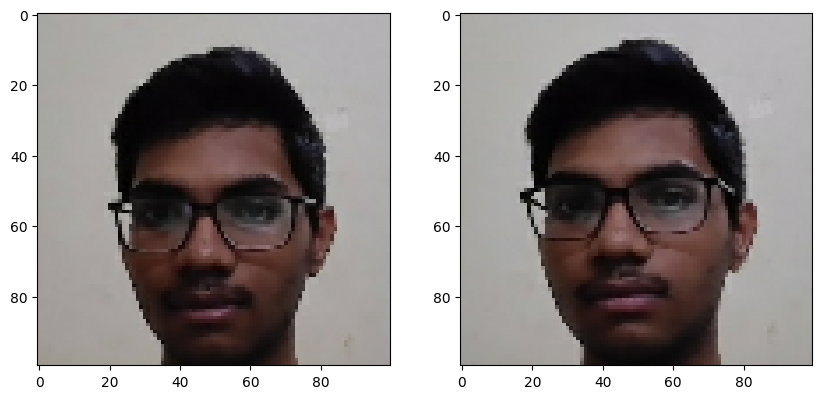

In [82]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [83]:
siamese_model.save('siamesemodel.h5')

In [84]:
L1Dist

__main__.L1Dist

In [85]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [86]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


array([[[9.9796557e-01],
        [6.6553043e-12],
        [9.9998420e-01],
        [9.9998301e-01],
        [9.9999982e-01],
        [5.3373437e-08],
        [1.0000000e+00],
        [9.9917871e-01],
        [1.0000000e+00],
        [9.9999374e-01],
        [3.5678670e-06],
        [7.5966600e-10],
        [9.9988770e-01],
        [5.1214141e-07],
        [4.0697484e-12],
        [9.6674600e-13]]], dtype=float32)

In [87]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_2 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (2818603333.py, line 1)

In [89]:
os.listdir(os.path.join('application_data', 'verification_images'))

['72812448-4f4b-11ef-ad5e-a0b2a256553f.jpg',
 '728f637e-4f4b-11ef-bcc1-a0b2a256553f.jpg',
 '729d7217-4f4b-11ef-8b6d-a0b2a256553f.jpg',
 '73318240-4f4b-11ef-902e-a0b2a256553f.jpg',
 '735a3a39-4f4b-11ef-8176-a0b2a256553f.jpg',
 '736d572e-4f4b-11ef-b837-a0b2a256553f.jpg',
 '737b5cf5-4f4b-11ef-86d1-a0b2a256553f.jpg',
 '741b17c0-4f4b-11ef-8346-a0b2a256553f.jpg',
 '744d1f8a-4f4b-11ef-81d2-a0b2a256553f.jpg',
 '745b4333-4f4b-11ef-9106-a0b2a256553f.jpg',
 '74779244-4f4b-11ef-adf2-a0b2a256553f.jpg',
 '749b93c8-4f4b-11ef-b612-a0b2a256553f.jpg',
 '752ff04a-4f4b-11ef-9651-a0b2a256553f.jpg',
 '7b633718-4f4b-11ef-95b1-a0b2a256553f.jpg',
 '7bc6df1b-4f4b-11ef-b489-a0b2a256553f.jpg',
 '7bd56253-4f4b-11ef-b35c-a0b2a256553f.jpg',
 '7bed52b2-4f4b-11ef-a442-a0b2a256553f.jpg',
 '7bf93ae6-4f4b-11ef-8448-a0b2a256553f.jpg',
 '7c4c11ac-4f4b-11ef-b81e-a0b2a256553f.jpg',
 '7c5a3de6-4f4b-11ef-aa2b-a0b2a256553f.jpg',
 '7d1b2b70-4f4b-11ef-a9f7-a0b2a256553f.jpg',
 '7d294d67-4f4b-11ef-a17b-a0b2a256553f.jpg',
 '7d375ac9

In [90]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [91]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\72812448-4f4b-11ef-ad5e-a0b2a256553f.jpg
application_data\verification_images\728f637e-4f4b-11ef-bcc1-a0b2a256553f.jpg
application_data\verification_images\729d7217-4f4b-11ef-8b6d-a0b2a256553f.jpg
application_data\verification_images\73318240-4f4b-11ef-902e-a0b2a256553f.jpg
application_data\verification_images\735a3a39-4f4b-11ef-8176-a0b2a256553f.jpg
application_data\verification_images\736d572e-4f4b-11ef-b837-a0b2a256553f.jpg
application_data\verification_images\737b5cf5-4f4b-11ef-86d1-a0b2a256553f.jpg
application_data\verification_images\741b17c0-4f4b-11ef-8346-a0b2a256553f.jpg
application_data\verification_images\744d1f8a-4f4b-11ef-81d2-a0b2a256553f.jpg
application_data\verification_images\745b4333-4f4b-11ef-9106-a0b2a256553f.jpg
application_data\verification_images\74779244-4f4b-11ef-adf2-a0b2a256553f.jpg
application_data\verification_images\749b93c8-4f4b-11ef-b612-a0b2a256553f.jpg
application_data\verification_images\752ff04a-4f4b-11ef-9651-a0b

In [92]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        result=result[0]
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [93]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: application_data\input_image\input_image.jpg : The system cannot find the path specified.
; No such process [Op:ReadFile]